In [1]:
from qiskit import *
from qiskit.converters import circuit_to_dag
from qiskit.quantum_info import Operator
from qiskit.circuit.library.standard_gates import CPhaseGate, PhaseGate
from qiskit.circuit.library import QFT
from qiskit.visualization import array_to_latex

import quimb as qu
import quimb.tensor as qtn

import numpy as np

# Full QFT MPO circuit implementation

In [65]:
# Num qubits
N = 4
# 10 qubits and tag the initial wavefunction tensors
circ = qtn.Circuit(N=N)
circ.apply_gate('H', 0, gate_round=0)

circ.apply_gate_raw(CPhaseGate(np.pi/2).to_matrix(), [0, 1], gate_round=0, tags='P(pi/2)')
circ.apply_gate_raw(PhaseGate(np.pi/4).to_matrix(), [2], gate_round=0, tags='P(pi/4)')
circ.apply_gate_raw(PhaseGate(np.pi/8).to_matrix(), [3], gate_round=0, tags='P(pi/8)')

circ.apply_gate('H', 1, gate_round=0)
circ.apply_gate_raw(CPhaseGate(np.pi/2).to_matrix(), [1, 2], gate_round=0)
circ.apply_gate_raw(CPhaseGate(np.pi/4).to_matrix(), [1, 3], gate_round=0)

circ.apply_gate('H', 2, gate_round=0)
circ.apply_gate_raw(CPhaseGate(np.pi/2).to_matrix(), [2, 3], gate_round=0)

circ.apply_gate('H', 3, gate_round=0)

circ_tensors = circ.psi.tensors

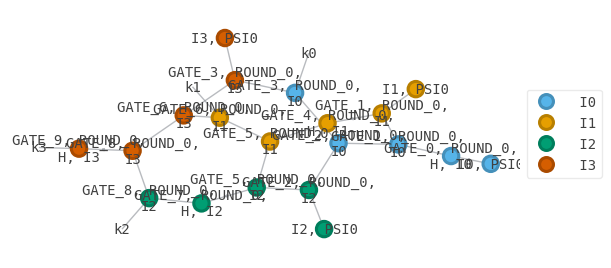

In [4]:
circ.psi.draw(color=[f'I{q}' for q in range(N)])

# Phase Tensor MPO

In [106]:
def get_phase_MPO(N):

    tensors = []
    copy_tensor = qtn.Tensor(data=np.array([ [[1, 0], [0,0]], [[0, 0], [0, 1]] ]), inds=['k0_in', '0', 'k0_out'], tags=['I'])
    tensors.append(copy_tensor)
    
    for i in range(0, N-1):
        phase_denom = (2**(i+1))
        phase = np.pi/phase_denom
        inds=[f'k{i+1}_in', f'{i}', f'{i+1}', f'k{i+1}_out']
        tensors.append(qtn.Tensor(data=CPhaseGate(phase).to_matrix().reshape(2,2,2,2), inds=inds, tags=['P', f'$\pi$/{phase_denom}']))

    # # Combine our phase gates
    # for i in range(2, N-1):
    #     tensors[i].new_bond(tensors[i+1], size=1)


    tn = qtn.TensorNetwork(tensors)
    print(tn)
    return tn

    

TensorNetwork([
    Tensor(shape=(2, 2, 2), inds=('k0_in', '0', 'k0_out'), tags=oset(['I'])),
    Tensor(shape=(2, 2, 2, 2), inds=('k1_in', '0', '1', 'k1_out'), tags=oset(['P', '$\\pi$/2'])),
    Tensor(shape=(2, 2, 2, 2), inds=('k2_in', '1', '2', 'k2_out'), tags=oset(['P', '$\\pi$/4'])),
    Tensor(shape=(2, 2, 2, 2), inds=('k3_in', '2', '3', 'k3_out'), tags=oset(['P', '$\\pi$/8'])),
])


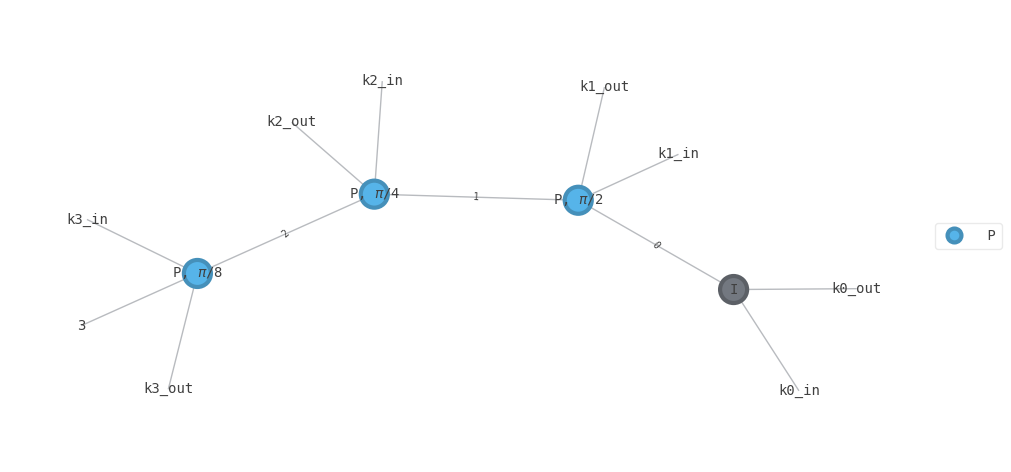

In [107]:
tensor_mpo = get_phase_MPO(N)
tensor_mpo.draw(color=['P'], figsize=(10, 10), show_inds='all', show_tags=True)

In [99]:
print(tensor_mpo.tensors[0].data)

[[[1 0]
  [0 0]]

 [[0 0]
  [0 1]]]


In [146]:
sorted_circ_tensors = circ.psi.tensors

for i in range(0, len(sorted_circ_tensors), 1):
    print(f"{i}: {sorted_circ_tensors[i]}")


# Contract phase tensors
contracted_tensor = sorted_circ_tensors[10] @ sorted_circ_tensors[15]

print(contracted_tensor)

# Split the tensor with svd
svd_tn = qtn.tensor_core.tensor_split(contracted_tensor, left_inds='_fe41d3AAAAI')

print(svd_tn)



0: Tensor(shape=(2,), inds=('_fe41d3AAABM',), tags=oset(['I0', 'PSI0']), backend='numpy', dtype='complex128')
1: Tensor(shape=(2,), inds=('_fe41d3AAABO',), tags=oset(['I1', 'PSI0']), backend='numpy', dtype='complex128')
2: Tensor(shape=(2,), inds=('_fe41d3AAABP',), tags=oset(['I2', 'PSI0']), backend='numpy', dtype='complex128')
3: Tensor(shape=(2,), inds=('_fe41d3AAABQ',), tags=oset(['I3', 'PSI0']), backend='numpy', dtype='complex128')
4: Tensor(shape=(2, 2), inds=('_fe41d3AAABN', '_fe41d3AAABM'), tags=oset(['GATE_0', 'ROUND_0', 'H', 'I0']), backend='numpy', dtype='complex128')
5: Tensor(shape=(2, 2, 2), inds=('k0', '_fe41d3AAABN', 'b'), tags=oset(['P(pi/2)', 'GATE_1', 'ROUND_0', 'I0']), backend='numpy', dtype='complex128')
6: Tensor(shape=(2, 2, 2), inds=('b', 'k1', '_fe41d3AAABO'), tags=oset(['P(pi/2)', 'GATE_1', 'ROUND_0', 'I1']), backend='numpy', dtype='complex128')
7: Tensor(shape=(2, 2), inds=('k2', '_fe41d3AAABP'), tags=oset(['P(pi/4)', 'GATE_2', 'ROUND_0', 'I2']), backend='nump

IndexError: tuple index out of range

In [ ]:
circ.schrodinger_contract()